In [1]:
# Import the necessary packages

# For calculating
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# load the data
df = pd.read_csv("data/Train.csv", sep=",")
df.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


## Checking the date of flight vs delays

In [4]:
# Convert DATOP to datetime
df['DATOP'] = pd.to_datetime(df['DATOP'], format="%Y-%m-%d", errors='coerce')  

# # Check if FLTID can be converted to numeric
# df['FLTID'] = pd.to_numeric(df['FLTID'], errors='coerce')  # Converts if possible

# Check the result
print(df[['DATOP', 'FLTID']].dtypes)


DATOP    datetime64[ns]
FLTID            object
dtype: object


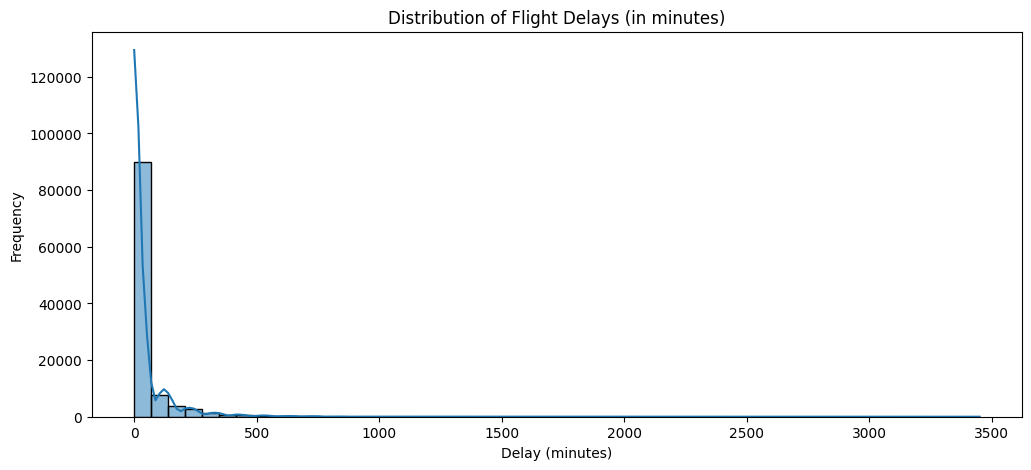

In [5]:
# check: Distribution of Flight Delays (in minutes)
# Set figure size
plt.figure(figsize=(12,5))

# Histogram of Flight Delays
sns.histplot(df['target'], bins=50, kde=True)
plt.title('Distribution of Flight Delays (in minutes)')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')
plt.show()


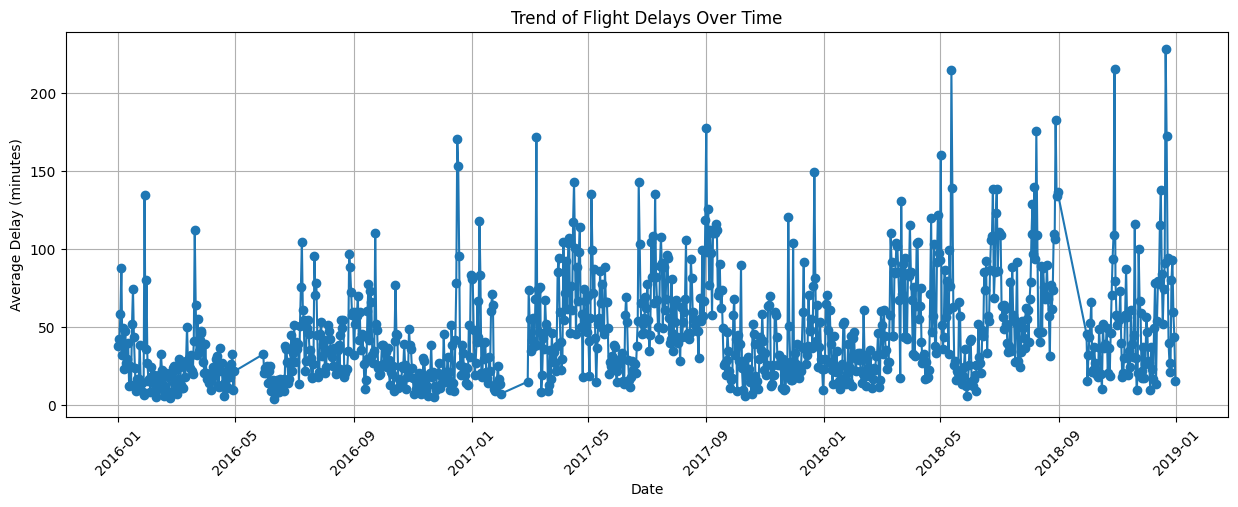

In [6]:
# how flight delays change over time?
# 1. Aggregate delays per day.
# 2. Plot the trend over time.

# Aggregate mean delay per day
daily_delays = df.groupby('DATOP')['target'].mean()
    
# Plot time-series trend
plt.figure(figsize=(15,5))
plt.plot(daily_delays.index, daily_delays.values, marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Average Delay (minutes)")
plt.title("Trend of Flight Delays Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Observations from the Trend Plot 

**Seasonal Patterns**

There are recurring spikes, suggesting certain periods experience more delays.
Delays seem to increase around the same months each year—this could be due to holidays, weather, or high-traffic seasons.

**Sudden Peaks**

Some dates have extreme delay averages.
We need to investigate these anomalies (e.g., weather conditions, strikes, holidays).

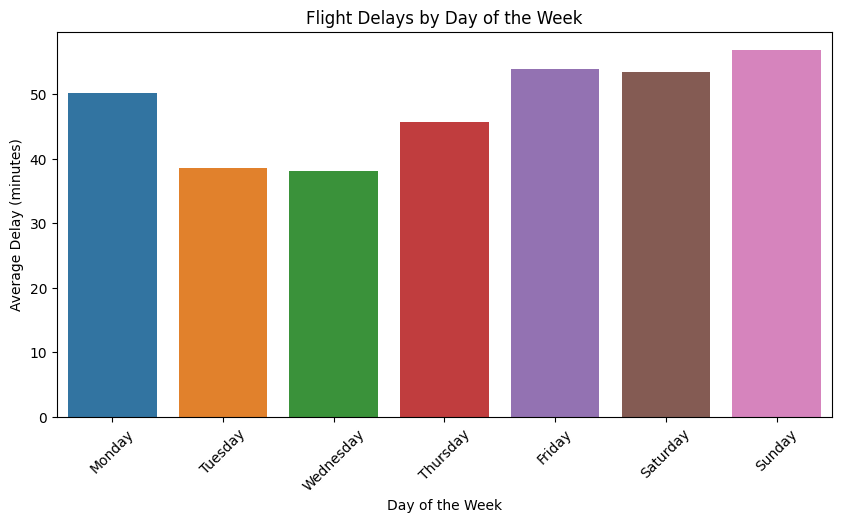

In [7]:
# DO delays follow a weekly pattern?

# Extract day of the week
df['DayOfWeek'] = df['DATOP'].dt.day_name()

# Aggregate mean delays per day
weekday_delays = df.groupby('DayOfWeek')['target'].mean()

# Order weekdays correctly
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=weekday_delays.index, y=weekday_delays.values, order=weekday_order)
plt.xlabel("Day of the Week")
plt.ylabel("Average Delay (minutes)")
plt.title("Flight Delays by Day of the Week")
plt.xticks(rotation=45)
plt.show()


Observations from Weekday Delays

**Delays Increase Toward the Weekend**

1. Monday has relatively high delays.
2. Tuesday and Wednesday have the lowest delays.
3. **Delays increase significantly on Friday, Saturday, and Sunday.**
   
**To be checked:**

1. Higher weekend travel demand → More flights, busier airports.
2. End-of-week congestion → Delays build up through the week.
2. Operational factors (e.g., reduced crew, scheduling inefficiencies).

## Checking flight numbers vs delays

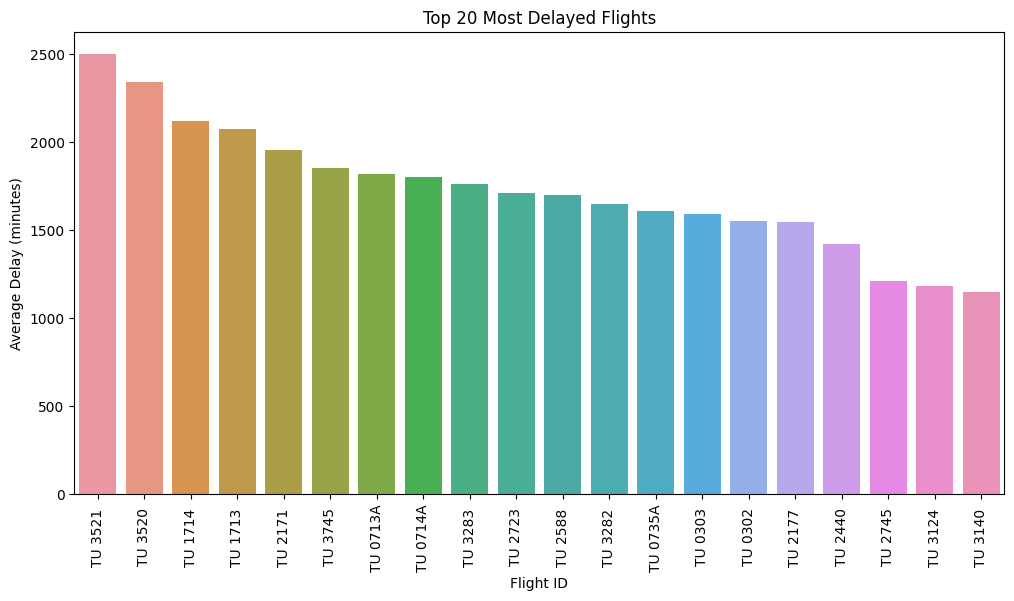

In [8]:
# Do certain flights experience more delays than others?
# Are delays consistent across flights or random?

# Re-run aggregation
flight_delays = df.groupby('FLTID')['target'].mean().sort_values(ascending=False)

# Plot again
plt.figure(figsize=(12,6))
sns.barplot(x=flight_delays.index[:20], y=flight_delays.values[:20])
plt.xlabel("Flight ID")
plt.ylabel("Average Delay (minutes)")
plt.title("Top 20 Most Delayed Flights")
plt.xticks(rotation=90)
plt.show()


Observations from the Flight-Specific Delays

**Certain Flights Have Extremely High Average Delays**

1. Some flights, like TU 3521 and TU 3520, have average delays exceeding 2500 minutes (over 41 hours!).
2. These flights likely experienced extreme operational issues, cancellations (?) (probably the rows that Eva mentioned?), or weather disruptions (though I wonder why weather disruption would affect only certain flights)

**Flight Number Patterns**

1. Some flights have similar numbers (e.g., TU 0713A & TU 0714A or TU 328 & TU 3282).
2. Could this indicate specific routes or airline-specific problems? 

In [11]:
# Do routes have anything to do with delays?
# Group by departure and arrival stations to see route-wise delays
route_delays = df.groupby(['DEPSTN', 'ARRSTN'])['target'].mean().sort_values(ascending=False)

# Convert to DataFrame for easier viewing
route_delays = route_delays.reset_index()

# Show top 20 most delayed routes
route_delays.head(20)


,DEPSTN,ARRSTN,target
0,LYS,CDG,2456.000000
1,TUN,SVO,2123.000000
2,ORY,MRS,770.000000
3,CAI,DJE,703.000000
4,ATH,SFA,653.000000
5,RTM,TUN,618.200000
6,MIR,NTE,609.000000
7,DJE,ORN,530.000000
8,LHR,LHR,529.400000
9,TUN,RTM,494.200000
